In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy import optimize
from matplotlib import cm
from math import isinf
from scipy.optimize import linprog
import random

In [ ]:
class NonStationaryBetaEnv:
    """
    A highly non-stationary environment where:
    - Valuations are always in [0, 1]
    - The valuation distribution changes COMPLETELY at every round
    - Uses Beta distributions for flexibility in shape
    """
    
    def __init__(self, cost, prices, T):
        """
        Initialize the environment.
        
        Parameters:
        - T: Number of rounds
        - possible_prices: List of possible prices (must be in [0,1])
        """
        self.cost = cost
        self.prices = np.array(prices)
        self.T = T
        
        # Initial Beta distribution parameters (uniform)
        self.alpha = np.random.uniform(0.1, 10)
        self.beta = np.random.uniform(0.1, 10)
    
    def _update_distribution(self):
        """Drastically change the Beta distribution parameters at EVERY round"""
    
        # change_mode = np.random.choice(['jump', 'drift', 'spike'])
        change_mode = 'drift'
        
        if change_mode == 'jump':
            # Sudden jump to new distribution
            self.alpha = np.random.uniform(0.1, 10)
            self.beta = np.random.uniform(0.1, 10)
            
        elif change_mode == 'drift':
            # Random walk drift
            self.alpha = np.clip(self.alpha * np.random.uniform(0.5, 1.5), 0.1, 10)
            self.beta = np.clip(self.beta * np.random.uniform(0.5, 1.5), 0.1, 10)
            
        else: # 'spike'
            # Create extreme distribution (very skewed)
            if np.random.rand() > 0.5:
                self.alpha = np.random.uniform(0.1, 0.5)  # Low valuations
                self.beta = np.random.uniform(5, 10)      # High skew
            else:
                self.alpha = np.random.uniform(5, 10)     # High skew
                self.beta = np.random.uniform(0.1, 0.5)   # High valuations
    
    
    def get_win_probability(self, t, price):
        """
        Probability valuation >= price when valuation ~ Beta(alpha_t, beta_t)
        """
        return 1 - stats.beta.cdf(price, self.alpha, self.beta)
    
    def get_win_probabilities(self, t):
        """Return an array of win probabilities for all prices at time t."""
        return np.array([self.get_win_probability(t, p) for p in self.prices])
    
    def round(self, t, n_customers, price):
        """
        Simulate a round at time t.
        Returns: (demand, revenue)
        """
        win_prob = self.get_win_probability(t, price)
        d_t = np.random.binomial(n_customers, win_prob)
        r_t = (price - self.cost) * d_t
        self._update_distribution()
        return d_t, r_t

In [25]:
class NonStationaryBetaEnv:
    """
    A highly non-stationary environment where:
    - Valuations are always in [0, 1]
    - The valuation distribution changes COMPLETELY at every round
    - Uses Beta distributions for flexibility in shape
    """
    
    def __init__(self, cost, prices, T):
        """
        Initialize the environment.
        
        Parameters:
        - T: Number of rounds
        - possible_prices: List of possible prices (must be in [0,1])
        """
        self.cost = cost
        self.prices = np.array(prices)
        self.T = T
        self.alphas = np.ones(self.T)
        self.betas = np.ones(self.T)

        
        # Initial Beta distribution parameters (uniform)
        self.alpha = np.random.uniform(0.1, 10)
        self.beta = np.random.uniform(0.1, 10)
        self._get_valuations()

    def _get_valuations(self):
        for t in range(self.T):
            self.alphas[t] = self.alpha
            self.betas[t] = self.beta
            self._update_distribution()
        return    

    def _update_distribution(self):
        """Drastically change the Beta distribution parameters at EVERY round"""
    
        # change_mode = np.random.choice(['jump', 'drift', 'spike'])
        change_mode = 'drift'
        
        if change_mode == 'jump':
            # Sudden jump to new distribution
            self.alpha = np.random.uniform(0.1, 10)
            self.beta = np.random.uniform(0.1, 10)
            
        elif change_mode == 'drift':
            # Random walk drift
            self.alpha = np.clip(self.alpha * np.random.uniform(0.5, 1.5), 0.1, 10)
            self.beta = np.clip(self.beta * np.random.uniform(0.5, 1.5), 0.1, 10)
            
        else: # 'spike'
            # Create extreme distribution (very skewed)
            if np.random.rand() > 0.5:
                self.alpha = np.random.uniform(0.1, 0.5)  # Low valuations
                self.beta = np.random.uniform(5, 10)      # High skew
            else:
                self.alpha = np.random.uniform(5, 10)     # High skew
                self.beta = np.random.uniform(0.1, 0.5)   # High valuations
    
    
    def get_win_probability(self, t, price):
        """
        Probability valuation >= price when valuation ~ Beta(alpha_t, beta_t)
        """
        return 1 - stats.beta.cdf(price, self.alphas[t], self.betas[t])
    
    def get_win_probabilities(self, t):
        """Return an array of win probabilities for all prices at time t."""
        return np.array([self.get_win_probability(t, p) for p in self.prices])
    
    def round(self, t, n_customers, price):
        """
        Simulate a round at time t.
        Returns: (demand, revenue)
        """
        win_prob = self.get_win_probability(t, price)
        d_t = np.random.binomial(n_customers, win_prob)
        r_t = (price - self.cost) * d_t
        return d_t, r_t

In [26]:
class EXP3PAgent:
    def __init__(self, K, T, alpha, gamma):
        self.K = K
        self.T = T
        self.alpha = alpha
        self.gamma = gamma
        self.a_t = None

        # Initialize weights
        self.weights = np.exp((self.alpha * self.gamma / 3) * np.sqrt(self.T / self.K)) * np.ones(self.K)
        self.probs = np.ones(self.K) / self.K
        self.t = 0
        self.N_pulls = np.zeros(self.K)


    def pull_arm(self):
        # Compute probability distribution
        self.probs = (1 - self.gamma) * (self.weights / np.sum(self.weights)) + (self.gamma / self.K)
        
        # Choose arm
        self.a_t = np.random.choice(np.arange(self.K), p=self.probs)
        return self.a_t

    def update(self, reward):
        self.t += 1
        self.N_pulls[self.a_t] += 1
        i = self.a_t
        
        # Unbiased reward estimator
        x_hat = np.zeros(self.K)
        x_hat[i] = reward / self.probs[i]
        
        # Bias correction
        x_hat[i] += self.alpha / (self.probs[i] * np.sqrt(self.K * self.T))
        
        # Update weights
        self.weights[i] *= np.exp((self.gamma / (3 * self.K)) * (x_hat[i]))


In [27]:
class FFMultiplicativePacingAgent:
    def __init__(self, prices, budget, T, eta, K):
        self.prices = prices
        self.K = K
        self.T = T
        self.exp3 = EXP3PAgent(self.K, self.T, 2*np.sqrt(self.K * self.T), min(3/5, 2 * np.sqrt((3 * self.K * np.log(self.K)) / (5 * self.T))))
        self.budget = budget
        self.eta = eta
        self.rho = self.budget/self.T
        self.lmbd = 1
        self.t = 0
        self.N_pulls = np.zeros(len(prices))
        self.price_index = 0

    def pull_arm(self):
        if self.budget < 1:
            self.price_index = 0
            return -1
        self.price_index = self.exp3.pull_arm()
        return self.price_index
    def update(self, f_t, c_t):
        # update exp3
        L = f_t - self.lmbd*(c_t-self.rho)
        
        self.exp3.update(L) # we need to maximize L

        # update lagrangian multiplier
        self.lmbd = np.clip(self.lmbd-self.eta*(self.rho-c_t), 
                            a_min=0, a_max=1/self.rho)
        # update budget
        self.budget -= c_t
        # log
        self.N_pulls[self.price_index] += 1

In [21]:
def compute_clairvoyant(prices, rho, win_probabilities, cost=0.0):
    # maximize expected reward per round: (price-cost)*win_prob
    c = - (prices - cost) * win_probabilities
    A_ub = [win_probabilities]
    b_ub = [rho]
    A_eq = [np.ones(len(prices))]
    b_eq = [1.0]
    res = optimize.linprog(c, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq,
                           bounds=(0,1), method='highs')
    gamma = res.x
    if not res.success:
    # Fallback: return zeros or uniform distribution
        return None, None
    return gamma, -res.fun


In [28]:
def best_overall_price(prices, T, cost, env):
    """
    Compute the single best price in hindsight over all T rounds.
    
    Returns:
    - best_price: the price that maximizes total expected revenue
    - total_expected_revenue: expected revenue at that price summed over all rounds
    """
    # Initialize array to store total expected revenue per price
    total_revenues = np.zeros(len(prices))
    
    for t in range(T):
        # expected revenue for all prices at round t
        expected_revenues = (prices - cost) * env.get_win_probabilities(t)
        total_revenues += expected_revenues  # sum over rounds
    
    # pick the price that gives maximum total expected revenue
    idx = np.argmax(total_revenues)
    best_price = prices[idx]
    total_expected_revenue = total_revenues[idx]
    
    return best_price, total_expected_revenue


In [22]:
n_t = 1
T = 5000
B = 2200
rho = B/T
epsilon = T**(-0.33)
eta = T**(-0.5)
K = int(1/epsilon)
prices = np.linspace(0,1,K)
n_epochs = 20
all_regrets = []
all_payments = []
all_pulls = []
for i in range(n_epochs):

    agent = FFMultiplicativePacingAgent(prices, B, T, eta, K)
    env = NonStationaryBetaEnv(0, prices, T)
    utilities = []
    my_prices = []
    my_payments = []
    total_wins = 0
    clairv_util = []

    np.random.seed(i)
    for u in range(T):
        # env.set()
        gamma, exp_clairv_util = compute_clairvoyant(prices, rho, env.get_win_probabilities(u))
        if gamma is None:
            gamma = np.ones_like(prices) / len(prices)  # Uniform distribution
            exp_clairv_util = np.sum((prices - 0) * env.get_win_probabilities(u) * gamma)
        # interaction
        index = agent.pull_arm()
        if index != -1:
            my_price = prices[index]
            c_t, f_t = env.round(u, n_t, my_price)
            agent.update(f_t, c_t)
        else:
            f_t = 0
            my_price = prices[K-1]
            c_t = 0    
        # logging
        utilities.append(f_t)
        clairv_util.append(exp_clairv_util)
        my_prices.append(my_price)
        my_payments.append(c_t)
        total_wins+=c_t

    utilities = np.array(utilities)
    my_prices = np.array(my_prices)
    my_payments = np.array(my_payments)
    expected_clairvoyant_utility = np.array(clairv_util)
    print(f'Total # of Wins: {total_wins}')
    all_regrets.append(np.cumsum(expected_clairvoyant_utility-utilities))
    all_payments.append(np.cumsum(my_payments))
    all_pulls.append(agent.N_pulls)

avg_regret = np.array(all_regrets).mean(axis=0)
std_regret = np.array(all_regrets).std(axis=0)

avg_payments = np.array(all_payments).mean(axis=0)
std_payments = np.array(all_payments).std(axis=0)

avg_pulls = np.array(all_pulls).mean(axis=0)
std_pulls = np.array(all_pulls).std(axis=0)


Total # of Wins: 2139
Total # of Wins: 2117
Total # of Wins: 2200
Total # of Wins: 2018
Total # of Wins: 1927
Total # of Wins: 2012
Total # of Wins: 2054
Total # of Wins: 1963
Total # of Wins: 2072
Total # of Wins: 2008
Total # of Wins: 2159
Total # of Wins: 2200
Total # of Wins: 2049
Total # of Wins: 1898
Total # of Wins: 1701
Total # of Wins: 1951
Total # of Wins: 2048
Total # of Wins: 2076
Total # of Wins: 2025
Total # of Wins: 1869


In [29]:
n_t = 1
T = 5000
B = 2200
rho = B/T
epsilon = T**(-0.33)
eta = T**(-0.5)
K = int(1/epsilon)
prices = np.linspace(0,1,K)
n_epochs = 20
all_regrets = []
all_payments = []
all_pulls = []
for i in range(n_epochs):

    agent = FFMultiplicativePacingAgent(prices, B, T, eta, K)
    env = NonStationaryBetaEnv(0, prices, T)
    best_price, expected_clairvoyant_utility = best_overall_price(prices, T, 0, env)
    expected_clairvoyant_utility = np.repeat(expected_clairvoyant_utility, T)
    utilities = []
    my_prices = []
    my_payments = []
    total_wins = 0
    np.random.seed(i)
    for u in range(T):
        # interaction
        index = agent.pull_arm()
        if index != -1:
            my_price = prices[index]
            c_t, f_t = env.round(u, n_t, my_price)
            agent.update(f_t, c_t)
        else:
            f_t = 0
            my_price = prices[K-1]
            c_t = 0    
        # logging
        utilities.append(f_t)
        my_prices.append(my_price)
        my_payments.append(c_t)
        total_wins+=c_t

    utilities = np.array(utilities)
    my_prices = np.array(my_prices)
    my_payments = np.array(my_payments)
    print(f'Total # of Wins: {total_wins}')
    all_regrets.append(np.cumsum(expected_clairvoyant_utility-utilities))
    all_payments.append(np.cumsum(my_payments))
    all_pulls.append(agent.N_pulls)

avg_regret = np.array(all_regrets).mean(axis=0)
std_regret = np.array(all_regrets).std(axis=0)

avg_payments = np.array(all_payments).mean(axis=0)
std_payments = np.array(all_payments).std(axis=0)

avg_pulls = np.array(all_pulls).mean(axis=0)
std_pulls = np.array(all_pulls).std(axis=0)


Total # of Wins: 2097
Total # of Wins: 2075
Total # of Wins: 2012
Total # of Wins: 2197
Total # of Wins: 1997
Total # of Wins: 2048
Total # of Wins: 1691
Total # of Wins: 2047
Total # of Wins: 2054
Total # of Wins: 2187
Total # of Wins: 2075
Total # of Wins: 2200
Total # of Wins: 2094
Total # of Wins: 2026
Total # of Wins: 1976
Total # of Wins: 1967
Total # of Wins: 2153
Total # of Wins: 2023
Total # of Wins: 1936
Total # of Wins: 2035


<>:12: SyntaxWarning: invalid escape sequence '\s'
<>:21: SyntaxWarning: invalid escape sequence '\s'
<>:12: SyntaxWarning: invalid escape sequence '\s'
<>:21: SyntaxWarning: invalid escape sequence '\s'
C:\Users\digio\AppData\Local\Temp\ipykernel_19536\3884080784.py:12: SyntaxWarning: invalid escape sequence '\s'
  plt.ylabel('$\sum c_t$')
C:\Users\digio\AppData\Local\Temp\ipykernel_19536\3884080784.py:21: SyntaxWarning: invalid escape sequence '\s'
  plt.ylabel('$\sum R_t$')


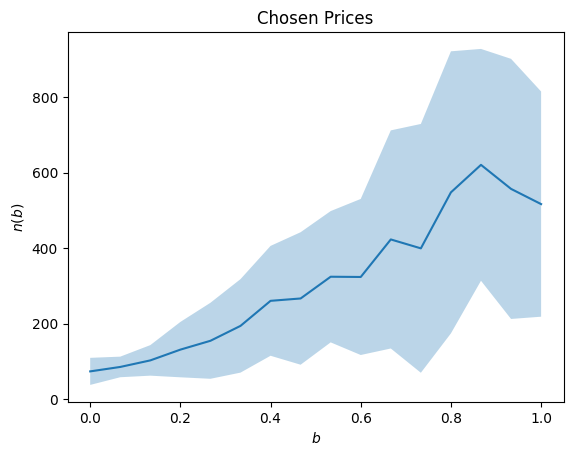

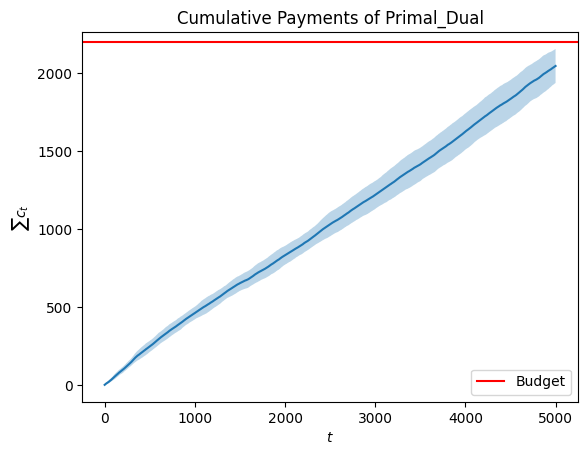

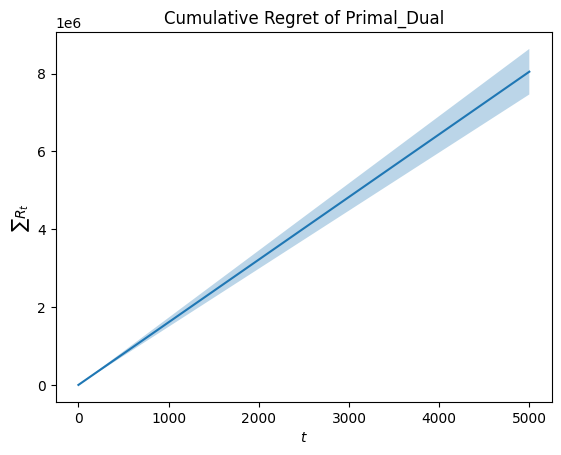

In [30]:
plt.plot(prices, avg_pulls)
plt.fill_between(prices, avg_pulls-std_pulls, avg_pulls+std_pulls, alpha=0.3)
plt.plot()
plt.xlabel('$b$')
plt.ylabel('$n(b)$')
plt.title('Chosen Prices')
plt.show()

plt.plot(np.arange(T), avg_payments)
plt.fill_between(np.arange(T), avg_payments-std_payments, avg_payments+std_payments, alpha=0.3)
plt.xlabel('$t$')
plt.ylabel('$\sum c_t$')
plt.axhline(B, color='red', label='Budget')
plt.legend()
plt.title('Cumulative Payments of Primal_Dual')
plt.show()

plt.plot(np.arange(T), avg_regret)
plt.fill_between(np.arange(T), avg_regret-std_regret, avg_regret+std_regret, alpha=0.3)
plt.xlabel('$t$')
plt.ylabel('$\sum R_t$')
plt.title('Cumulative Regret of Primal_Dual')
plt.show()